# Training Random Forest With N-2 Previous Data
*General Process:*
1. split up train/test data columns
2. create sequences of 3 for the training data: 
window_size = 3 # select 3 rows at a time
X_sequences = []
y_target = []
for i in range(len(X) - window_size):
    X_sequences.append(X[i:i+window_size])
    y_target.append(y[i+window_size]+1) # one night more than the trainig data goes up to
3. Format data into array

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
from astropy.io import fits
import fitsio
from scipy import stats
import sys, os, warnings
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, KFold

In [2]:
# Load the table processed from generated_tables folder
fpath = 'generated_tables/'

# Load the df generated from the remove_time_gaps.py and get_night.py
shifted_full = Table(fitsio.read(fpath+'shifted_table.fits')).to_pandas()
shifted_full

,mirror_cooling,temperature,pressure,humidity,wind_speed,wind_direction,mirror_temp,air_temp,mirror_cooling_var,temperature_var,pressure_var,humidity_var,wind_speed_var,wind_direction_var,mirror_temp_var,air_temp_var,obsday,adjusted_desired_temp,air_temp_nextday
0,0.662218,20.846477,793.885798,30.110657,10.325268,316.762562,20.340664,21.838363,0.222283,1.121938,0.864430,5.197696,7.223977,275.512328,0.263264,4.092305,2021-09-15,18.0,21.935603
1,0.601317,21.453405,793.496934,33.679609,9.568663,169.116535,20.381133,21.935603,0.238845,2.896639,0.404218,33.033023,27.494060,4876.835674,0.276811,4.534386,2021-09-16,18.0,20.452457
2,0.670060,19.348314,796.483708,53.821591,5.919081,136.602343,18.581965,20.452457,0.214482,0.617031,0.477390,43.390580,5.111971,6407.702694,0.468626,1.965519,2021-09-17,18.0,19.840065
3,0.607054,18.124226,795.954992,77.304527,9.489310,174.769908,18.539266,19.840065,0.238509,1.130825,1.230947,87.270898,39.647019,5437.799939,0.347746,1.877360,2021-09-18,18.0,19.801253
4,0.820000,18.435370,793.885757,56.468469,14.201635,169.605956,18.239396,19.801253,0.144727,1.745180,0.849827,473.589945,49.491711,2375.040069,0.114214,2.293055,2021-09-19,18.0,19.573302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,1.000000,4.533968,795.000000,23.233633,29.736987,107.191097,0.763877,4.533253,0.000000,2.514957,0.000000,32.061395,180.518908,167.256263,0.364793,1.523822,2023-02-17,4.0,7.790498
411,0.932275,6.787604,795.000000,53.587232,15.043157,132.737188,4.543186,7.790498,0.062277,2.864519,0.000000,56.212117,78.637620,756.692312,3.008891,2.613771,2023-02-18,4.0,7.350313
412,1.000000,5.772312,794.222696,69.271628,23.225928,131.953170,6.631846,7.350313,0.000000,0.901035,1.342800,391.264808,65.742586,201.828787,0.094299,0.262968,2023-02-19,4.0,7.895247
413,1.000000,5.646588,790.502645,82.480356,12.207638,131.577236,7.122464,7.895247,0.000000,0.788047,4.064194,98.904790,31.691739,2177.325295,0.051339,0.513966,2023-02-20,4.0,5.761747


# Prepare Data for Random Forest

[1.93483142e+01 7.96483708e+02 5.38215905e+01 5.91908137e+00
 1.36602343e+02 1.85819654e+01 2.04524567e+01 2.14482454e-01
 6.17030541e-01 4.77390438e-01 4.33905804e+01 5.11197065e+00
 6.40770269e+03 4.68625620e-01 1.96551913e+00 1.80000000e+01
 1.81242256e+01 7.95954992e+02 7.73045271e+01 9.48931030e+00
 1.74769908e+02 1.85392657e+01 1.98400647e+01 2.38508728e-01
 1.13082473e+00 1.23094712e+00 8.72708983e+01 3.96470194e+01
 5.43779994e+03 3.47746264e-01 1.87735988e+00 1.80000000e+01
 1.84353701e+01 7.93885757e+02 5.64684688e+01 1.42016349e+01
 1.69605956e+02 1.82393964e+01 1.98012532e+01 1.44726596e-01
 1.74517975e+00 8.49827139e-01 4.73589945e+02 4.94917109e+01
 2.37504007e+03 1.14214338e-01 2.29305494e+00 1.80000000e+01]
19.573301770597762


Text(0, 0.5, 'predicted air_temp')

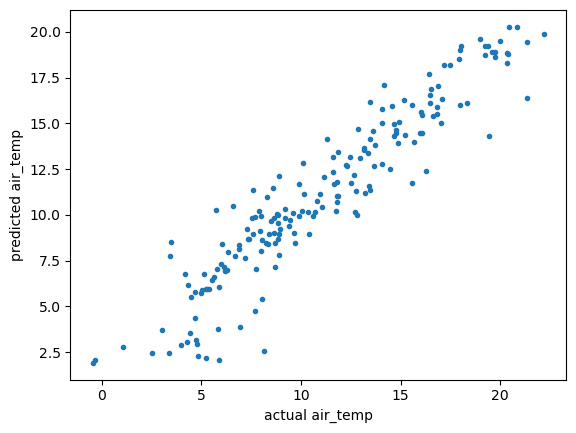

In [121]:
data = shifted_full.drop(columns=['air_temp_nextday'])
data['obsday'] = pd.to_datetime(data['obsday'])


# Step 1: Split data into input features (X) and target variable (y)
X = data.drop(columns='obsday').iloc[:, 1:]  # Assuming columns 1 and onward are features
y = data['air_temp']   # predicting the airtemp of the next day (the y indices will be appended with +1 to allow for this)

# Step 2: Create sequences of three consecutive rows of data
window_size = 3
X_sequences = []
y_target = []

for i in range(2, len(X) - window_size):
    current_obsday = data.iloc[i]['obsday']
    prev_obsday_1 = data.iloc[i - 1]['obsday']
    prev_obsday_2 = data.iloc[i - 2]['obsday']

    time_diff_1 = current_obsday - prev_obsday_1
    time_diff_2 = prev_obsday_1 - prev_obsday_2
    
    if abs(time_diff_1.days) <= 1 and abs(time_diff_2.days) <= 1:
        rows = np.concatenate(np.array(X[i:i+window_size]))
        X_sequences.append(rows)
        y_target.append(y[i+window_size])

# Convert lists to numpy arrays
X_sequences = np.array(X_sequences)
y_target = np.array(y_target)

print(X_sequences[0])
print(y_target[0])

# Step 4: Split the data into training and testing sets
idx_train, idx_test = train_test_split(np.arange(len(X_sequences)), test_size=0.5, random_state=6123)

# Step 5: Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_sequences[idx_train], y_target[idx_train])

# Step 6: Evaluate the model's performance
y_pred = rf_model.predict(X_sequences[idx_test])
plt.plot(y_target[idx_test], y_pred, '.')
plt.xlabel('actual air_temp')
plt.ylabel('predicted air_temp')

# Train/Test the Random Forest to predict Dome Tempratures

In [122]:
features = ['mirror_temp', 'mirror_temp_var', 'temperature', 'temperature_var'] #, 'mirror_desired_temp']
X = X_sequences
y = y_target
y = np.ravel(y)

In [123]:
# Split the training and testing set 50/50
idx_train, idx_test = train_test_split(np.arange(len(X)), test_size=0.5, random_state=6123)
# Define the random forest regressor
regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
print('Beginning 5-fold cross validation\n')

# With 5-fold cross validation
n_folds = 5
#kf creates the folds
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1456)
np.random.seed(123)
pred = np.zeros(len(X))
for kf_index, (idx_train, idx_test) in enumerate(kf.split(X)):
# there's a different idx_train and idx_test for each fold
    print('Fold %d'%(kf_index+1))
    regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
    regrf.fit(X[idx_train], y[idx_train])
    pred[idx_test] = regrf.predict(X[idx_test])
print('Finished 5-fold cross validation\n')

predictions = pred
actual = y


Beginning 5-fold cross validation

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Finished 5-fold cross validation



median absolute deviation: 1.0039003409873748


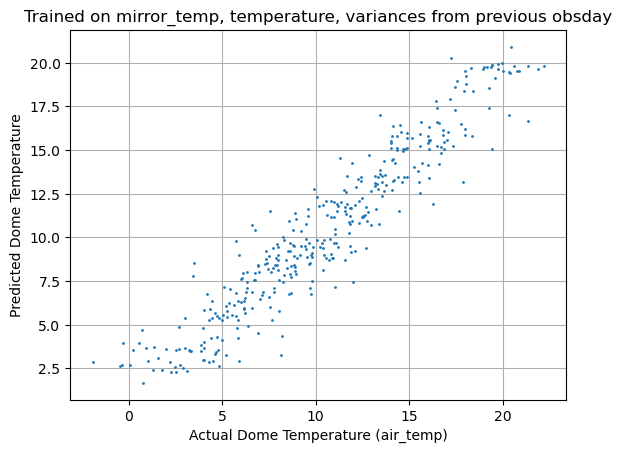

In [124]:
plt.plot(actual, predictions, '.', ms=2)
plt.grid()
plt.ylabel('Predicted Dome Temperature')
plt.xlabel('Actual Dome Temperature (air_temp)')
plt.title('Trained on mirror_temp, temperature, variances from previous obsday')
print('median absolute deviation:', np.median(np.abs((predictions - actual))))

Filter importance:
[0.77956463 0.03044342 0.15562125 0.03437071]


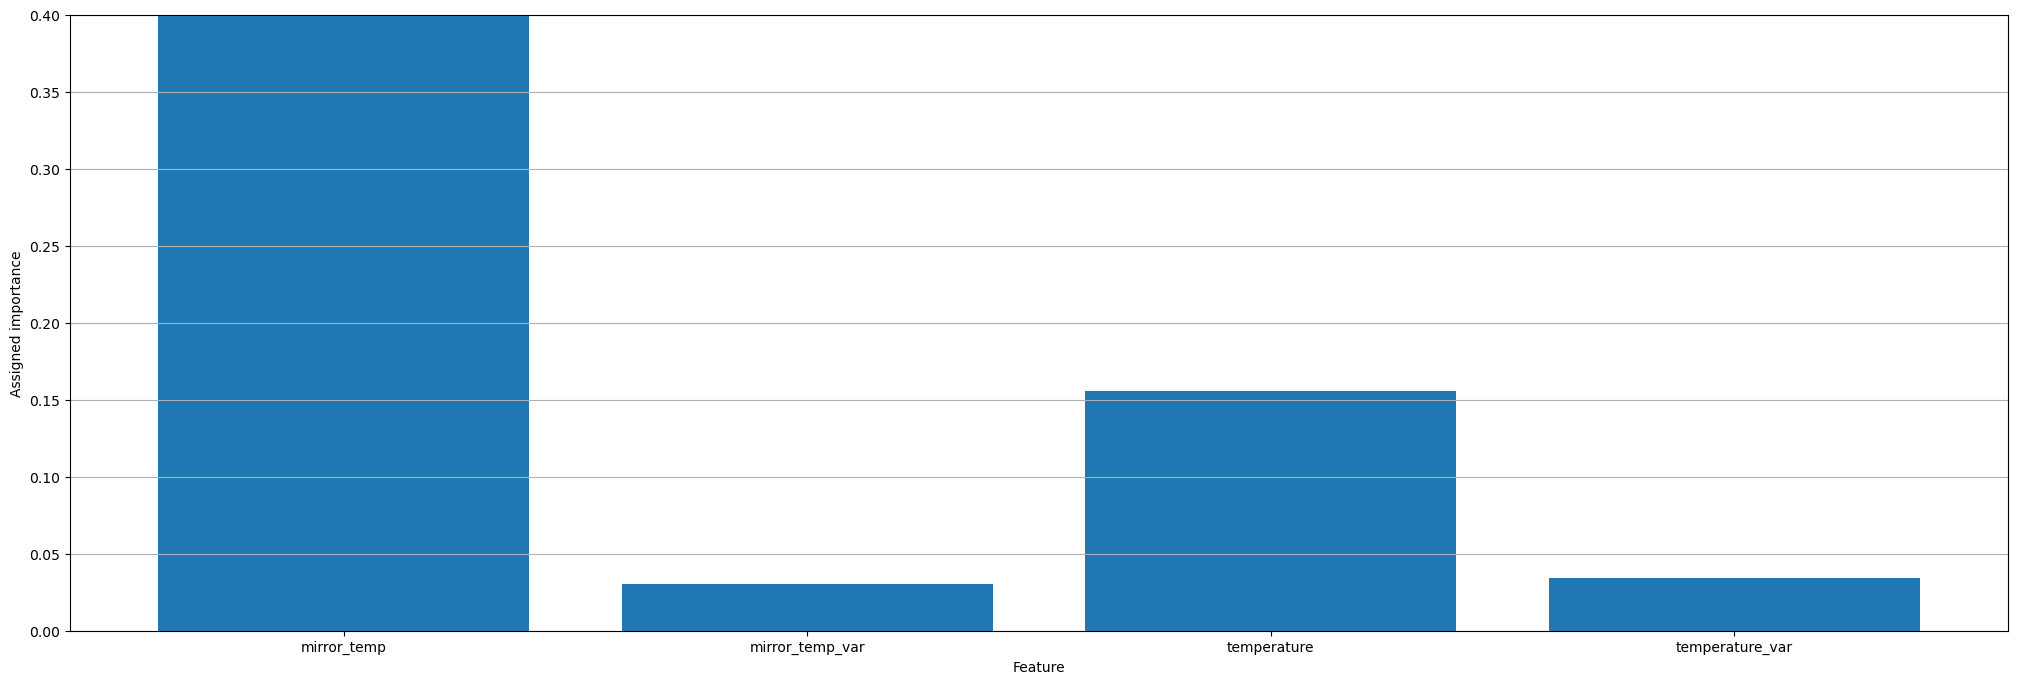

(array([1, 3, 2, 0]),)


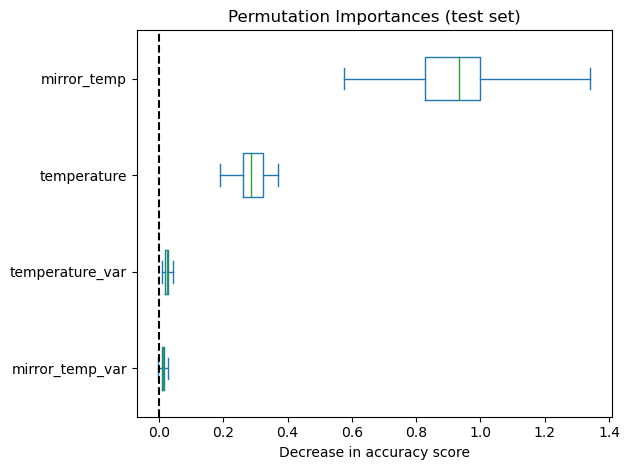

<Figure size 2500x2800 with 0 Axes>

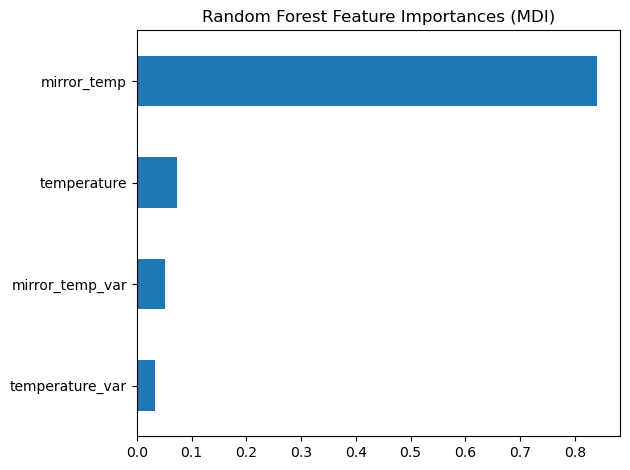

<Figure size 2500x2800 with 0 Axes>

NMAD = 0.12307
Outlier fraction = 43.33%


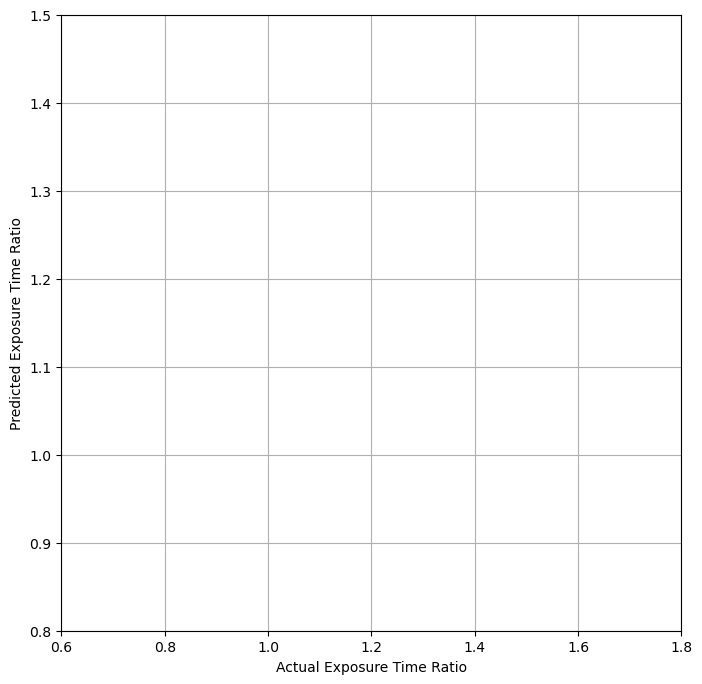

In [57]:
labels = features
x = np.arange(len(labels))

print('Filter importance:')
print(regrf.feature_importances_)
plt.figure(figsize=(25,8))
plt.bar(x, regrf.feature_importances_)
plt.xlabel('Feature')
plt.ylabel('Assigned importance')
plt.xticks(x, labels)
plt.grid(axis='y')
plt.ylim(0, 0.4)
plt.show()

from sklearn.inspection import permutation_importance
import pandas as pd

data = pd.DataFrame(columns=features)

result = permutation_importance(
    regrf, X[idx_test], y[idx_test], n_repeats=50, random_state=42, n_jobs=2
)
sorted_importances_idx = result.importances_mean.argsort()
sorted_importances_idx = sorted_importances_idx.astype(int),

print(sorted_importances_idx)
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=data.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.figure(figsize=(25,28))
plt.show()

# Vertical plot of the random forest importance

mdi_importances = pd.Series(
    regrf[-1].feature_importances_, index=features
).sort_values(ascending=True)
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()
plt.figure(figsize=(25,28))
plt.show()
etratio_pred = regrf.predict(X[idx_test])
etratio_actu = y[idx_test]

nmad = 1.48 * np.median(np.abs((etratio_pred - etratio_actu)/(1 + etratio_actu)))
outlier_threshold = 0.1
outlier_frac = np.sum(np.abs((etratio_pred - etratio_actu)/(1 + etratio_actu)) > outlier_threshold)/len(etratio_actu)
print('NMAD = {:.5f}'.format(nmad))
print('Outlier fraction = {:.2f}%'.format(outlier_frac*100))

plt.figure(figsize=(8, 8))
plt.plot(etratio_actu, etratio_pred, '.', markersize=1)
plt.xlabel('Actual Exposure Time Ratio')
plt.ylabel('Predicted Exposure Time Ratio')
plt.axis([0.6, 1.8, 0.8, 1.5])
plt.grid()
plt.show()
